# To-do:
# More visualisation

In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb
sb.set() 

In [2]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [3]:
nRowsRead = None # specify 'None' if want to read whole file
# cardio_train.csv has 70000 rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('cardio_train.csv', delimiter=';', nrows = nRowsRead)
df1.dataframeName = 'cardio_train.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')
df1

There are 70000 rows and 13 columns


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [4]:
#cardio_csv = pd.read_csv('cardio_train.csv', sep=';')
#cardio_csv.shape

In [5]:
print("Data Type: ", type(df1))
print(df1.dtypes)

Data Type:  <class 'pandas.core.frame.DataFrame'>
id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object


# BMI

In [6]:
df1['BMI'] = ((df1['weight']/(df1['height'] * df1['height'])) * 10000).round(decimals = 0).astype(np.int64)
df1

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,22
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,35
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,24
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,29
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,27
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1,50
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,31
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,27


# Convert age from days to years

In [7]:
df1['age'] = df1['age'].apply(lambda x: x/365).round(decimals = 0).astype(np.int64)
df1

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,22
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,35
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1,24
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,29
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,53,2,168,76.0,120,80,1,1,1,0,1,0,27
69996,99995,62,1,158,126.0,140,90,2,2,0,0,1,1,50
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1,31
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1,27


# Clean AP_HI and AP_LO Dataset
## Drop AP_HI(Systolic blood pressure) and AP_LO row(Diastolic blood pressure) with < 0 value

In [8]:
indexap_hi = df1[df1['ap_hi'] < 0].index
indexap_lo = df1[df1['ap_lo'] < 0].index
#print(indexNames)
df1.drop(indexap_hi , inplace=True)
df1.drop(indexap_lo , inplace=True)
#df1 = df1.drop(df1[df1.ap_hi < 115].index)

In [9]:
df1

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,22
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,35
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1,24
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,29
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,53,2,168,76.0,120,80,1,1,1,0,1,0,27
69996,99995,62,1,158,126.0,140,90,2,2,0,0,1,1,50
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1,31
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1,27


# Drop AP_HI(Systolic blood pressure) and AP_LO row(Diastolic blood pressure) that is way more/less than human threshold

### The threshold is determined by low blood pressure (AP_HI < 90mmHg or AP_LO < 60mmHG) and hypertensive crisis (AP_HI > 180mmHg or/and AP_LO > 120mmHG
#  It may be best to assume some AP_HI threshold between 75 to 200. Thus, rows that <75 and >200 are dropped

In [10]:
indexap_hi = df1[df1['ap_hi'] < 75].index
df1.drop(indexap_hi , inplace=True)
indexap_hi = df1[df1['ap_hi'] > 200].index
df1.drop(indexap_hi , inplace=True)

#df1.drop(indexap_lo , inplace=True)

In [11]:
#df1

#  It may be best to assume some AP_LO threshold between 45 to 140. Thus, rows that are <45 or >140 will be dropped

In [12]:
indexap_hi = df1[df1['ap_lo'] < 45].index
df1.drop(indexap_hi , inplace=True)
indexap_hi = df1[df1['ap_lo'] > 140].index
df1.drop(indexap_hi , inplace=True)

In [13]:
int64_items = pd.DataFrame(df1.select_dtypes(include = 'int64', exclude = None))
float64_items = pd.DataFrame(df1.select_dtypes(include = 'float64', exclude = None))

In [14]:
#df1

In [15]:
df1.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
count,68667.000000,68667.000000,68667.000000,68667.000000,68667.000000,68667.000000,68667.000000,68667.000000,68667.000000,68667.000000,68667.000000,68667.000000,68667.000000,68667.000000
mean,49976.184310,53.325251,1.348639,164.361178,74.113220,126.560546,81.328251,1.364396,1.225712,0.088004,0.053505,0.803428,0.494604,27.512735
std,28846.711059,6.768238,0.476543,8.183950,14.323022,16.536729,9.451296,0.678788,0.571698,0.283303,0.225039,0.397409,0.499975,6.057299
min,0.000000,30.000000,1.000000,55.000000,11.000000,80.000000,45.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,25002.500000,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,24.000000
50%,50012.000000,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.000000
75%,74875.000000,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.000000
max,99999.000000,65.000000,2.000000,250.000000,200.000000,200.000000,140.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,299.000000


In [16]:
age = pd.DataFrame(int64_items["age"])
age.describe()

,age
count,68667.000000
mean,53.325251
std,6.768238
min,30.000000
25%,48.000000
50%,54.000000
75%,58.000000
max,65.000000


<AxesSubplot:>

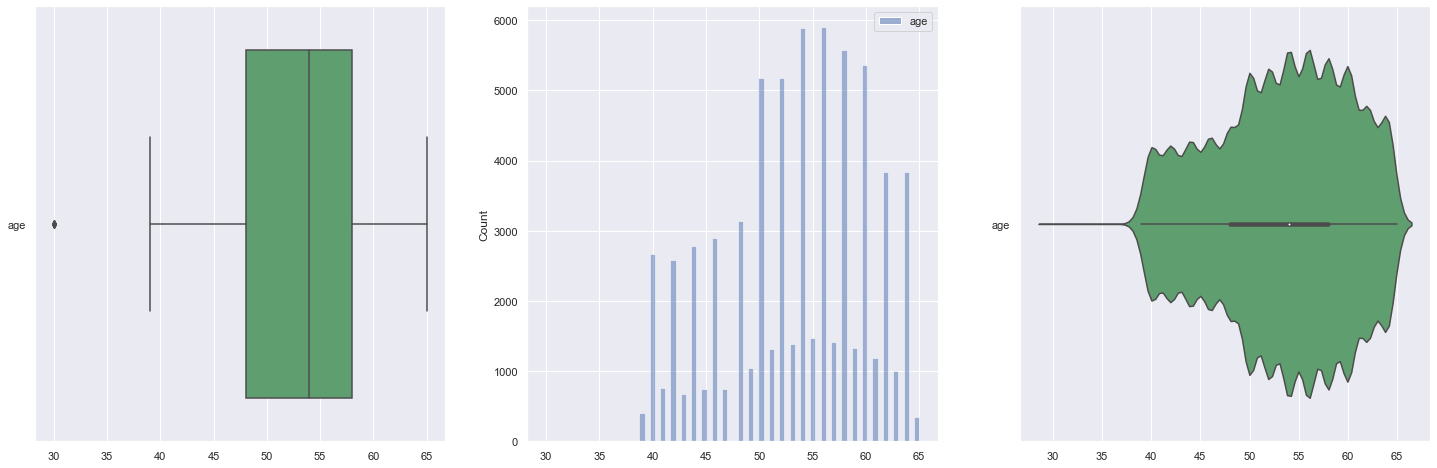

In [17]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = age, orient = "h", color = "g", ax = axes[0])
sb.histplot(data=age, color = "g", ax = axes[1])
sb.violinplot(data=age, orient='h', color = "g", ax = axes[2])

In [18]:
gender = pd.DataFrame(int64_items["gender"])
gender.describe()

,gender
count,68667.000000
mean,1.348639
std,0.476543
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


In [19]:
gender["gender"] = gender["gender"].replace({1:'Female', 2:"Male"}) #Cleaning gender dataset
gender

,gender
0,Male
1,Female
2,Female
3,Male
4,Female
...,...
69995,Male
69996,Female
69997,Male
69998,Female


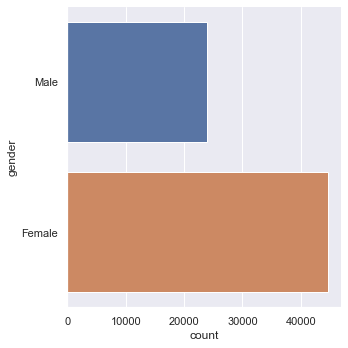

<Figure size 1728x288 with 0 Axes>

In [20]:
sb.catplot(y = 'gender', data = gender, kind = "count")
f = plt.figure(figsize = (24,4))

In [21]:
height = pd.DataFrame(int64_items["height"])
height.describe()

,height
count,68667.000000
mean,164.361178
std,8.183950
min,55.000000
25%,159.000000
50%,165.000000
75%,170.000000
max,250.000000


<AxesSubplot:>

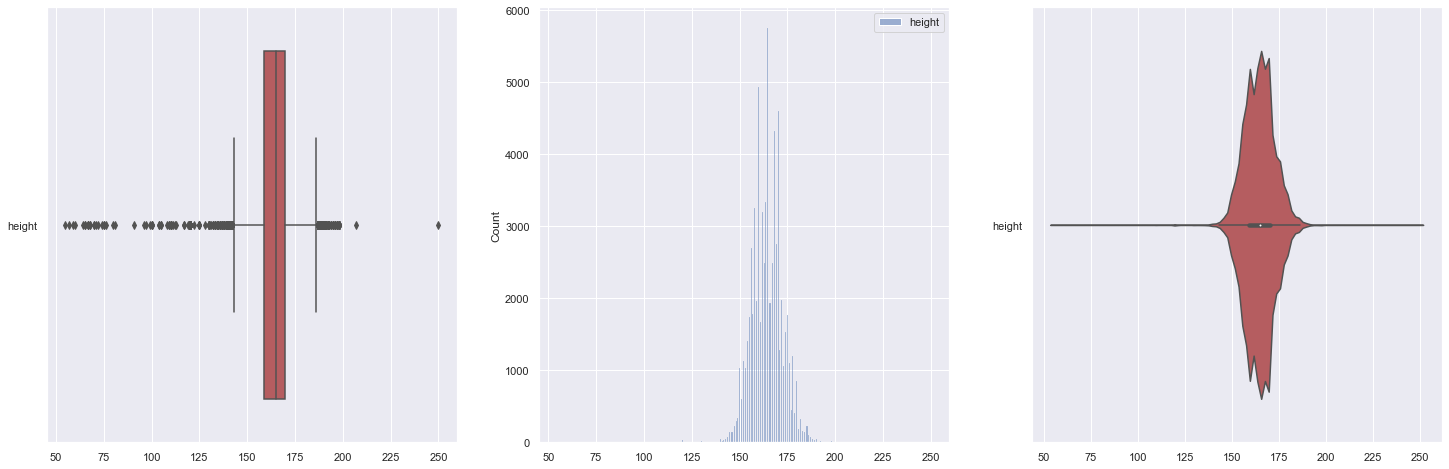

In [22]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = height, orient = "h", color = "r", ax = axes[0])
sb.histplot(data= height, color = "r", ax = axes[1])
sb.violinplot(data= height, orient='h', color = "r", ax = axes[2])

In [23]:
weight = pd.DataFrame(float64_items["weight"])
weight.describe()

,weight
count,68667.000000
mean,74.113220
std,14.323022
min,11.000000
25%,65.000000
50%,72.000000
75%,82.000000
max,200.000000


<AxesSubplot:>

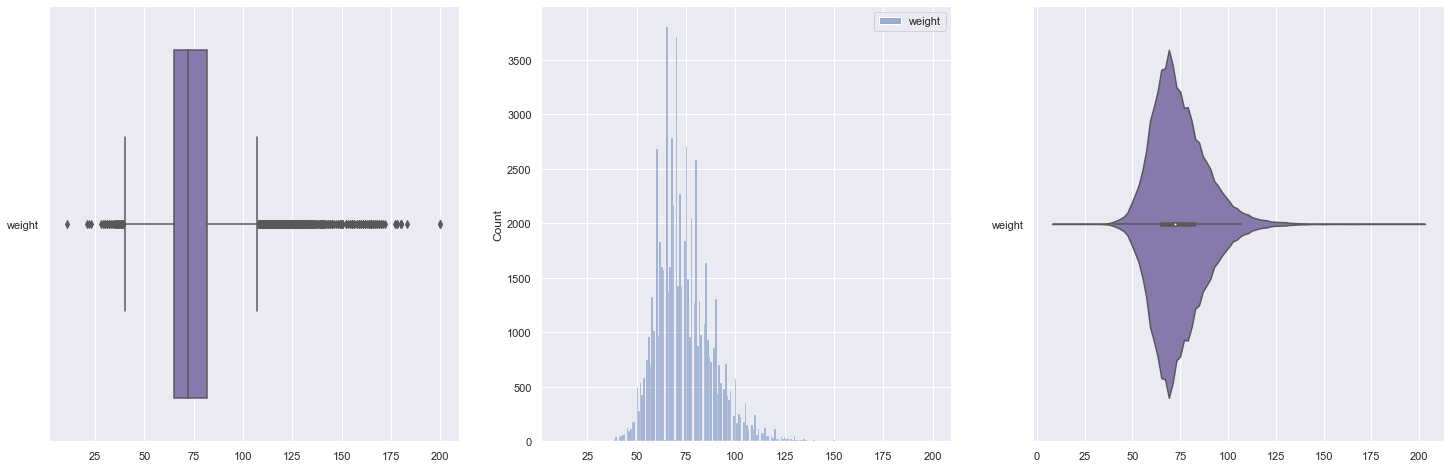

In [24]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = weight, orient = "h", color = "m", ax = axes[0])
sb.histplot(data= weight, color = "m", ax = axes[1])
sb.violinplot(data= weight, orient='h', color = "m", ax = axes[2])

# BMI

In [25]:
bmi = pd.DataFrame(int64_items["BMI"])

In [26]:
bmi.describe()

,BMI
count,68667.000000
mean,27.512735
std,6.057299
min,3.000000
25%,24.000000
50%,26.000000
75%,30.000000
max,299.000000


<AxesSubplot:>

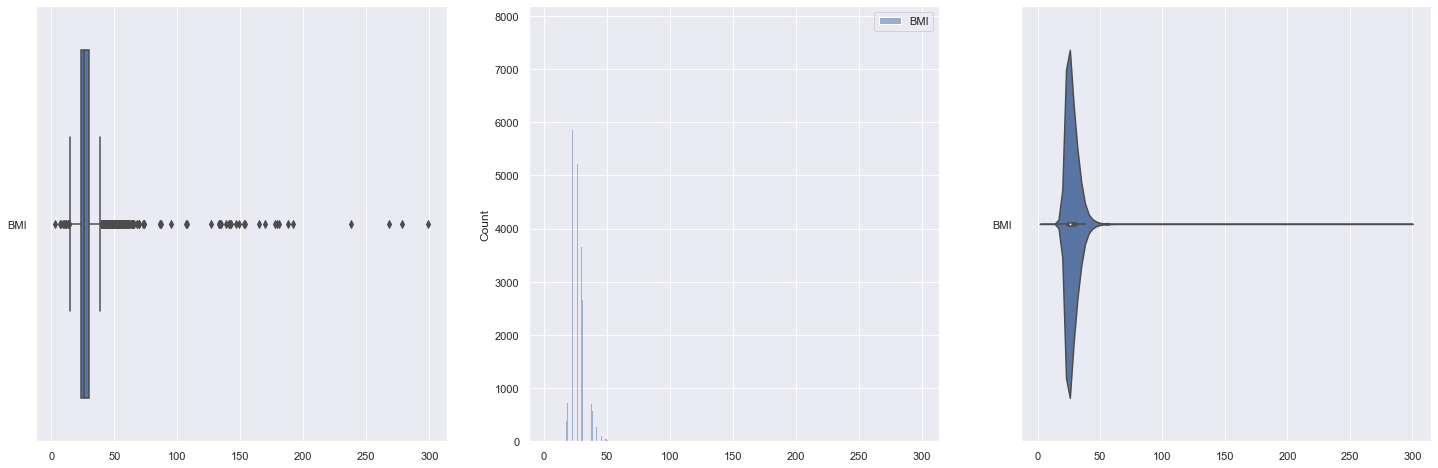

In [27]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = bmi, orient = "h", color = "b", ax = axes[0])
sb.histplot(data= bmi, color = "b", ax = axes[1])
sb.violinplot(data= bmi, orient='h', color = "b", ax = axes[2])

# AP_HI is Systolic blood pressure

In [28]:
ap_hi = pd.DataFrame(int64_items["ap_hi"])
ap_hi.describe()

,ap_hi
count,68667.000000
mean,126.560546
std,16.536729
min,80.000000
25%,120.000000
50%,120.000000
75%,140.000000
max,200.000000


<AxesSubplot:>

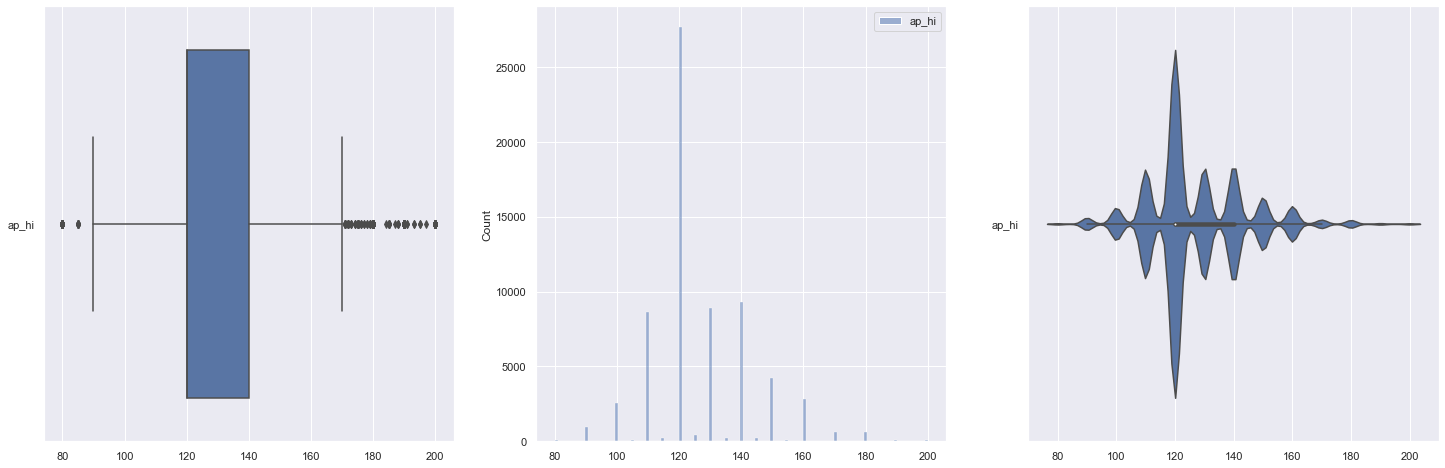

In [29]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = ap_hi, orient = "h", color = "b", ax = axes[0])
sb.histplot(data= ap_hi, color = "b", ax = axes[1])
sb.violinplot(data= ap_hi, orient='h', color = "b", ax = axes[2])

# AP_LO is Diastolic blood pressure 

In [30]:
ap_lo = pd.DataFrame(int64_items["ap_lo"])
ap_lo.describe()

,ap_lo
count,68667.000000
mean,81.328251
std,9.451296
min,45.000000
25%,80.000000
50%,80.000000
75%,90.000000
max,140.000000


<AxesSubplot:>

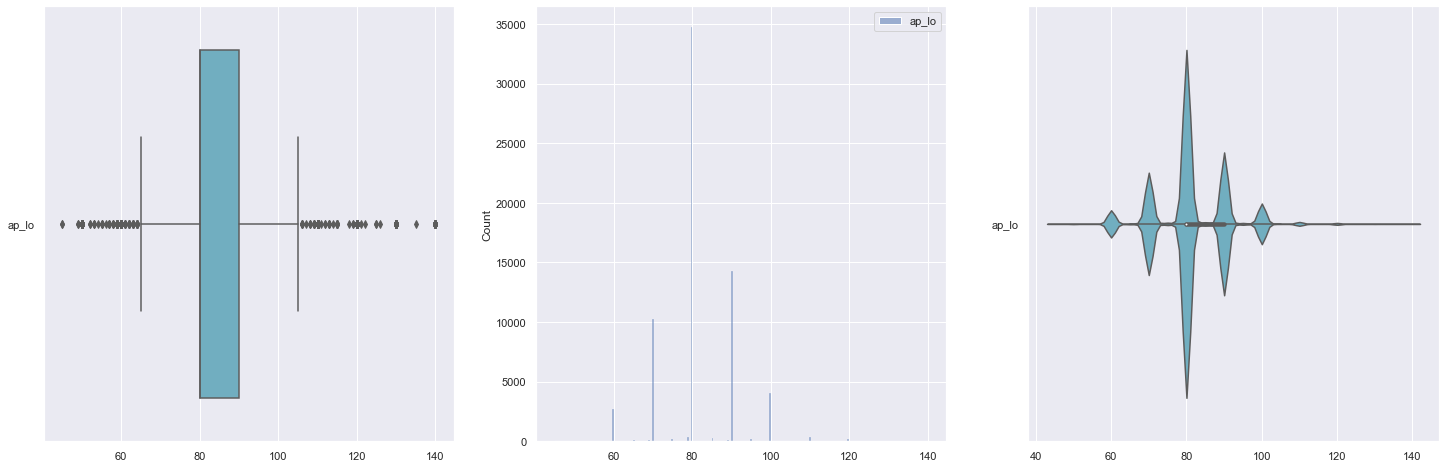

In [31]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = ap_lo, orient = "h", color = "c", ax = axes[0])
sb.histplot(data= ap_lo, color = "c", ax = axes[1])
sb.violinplot(data= ap_lo, orient='h', color = "c", ax = axes[2])

In [32]:
cholesterol = pd.DataFrame(int64_items["cholesterol"])
cholesterol.describe()

,cholesterol
count,68667.000000
mean,1.364396
std,0.678788
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,3.000000


In [33]:
cholesterol["cholesterol"] = cholesterol["cholesterol"].replace({1:'Normal', 2:"Above Normal", 3:"Well above normal"}) #Cleaning cholesterol dataset
cholesterol

,cholesterol
0,Normal
1,Well above normal
2,Well above normal
3,Normal
4,Normal
...,...
69995,Normal
69996,Above Normal
69997,Well above normal
69998,Normal


No. of categories in cholesterol: 3
Normal               51512
Above Normal          9288
Well above normal     7867
Name: cholesterol, dtype: int64


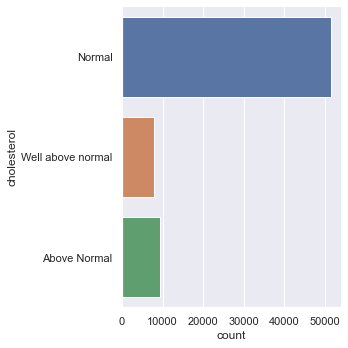

<Figure size 1728x288 with 0 Axes>

In [34]:
# Count of categories for variable "cholesterol"
print("No. of categories in cholesterol:", len(cholesterol["cholesterol"].unique()))
print(cholesterol["cholesterol"].value_counts())

sb.catplot(y = 'cholesterol', data = cholesterol, kind = "count")
f = plt.figure(figsize = (24,4))

In [35]:
glucose = pd.DataFrame(int64_items["gluc"])
glucose.describe()

,gluc
count,68667.000000
mean,1.225712
std,0.571698
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,3.000000


In [36]:
glucose["gluc"] = glucose["gluc"].replace({1:'Normal', 2:"Above Normal", 3:"Well above normal"}) #Cleaning glucose dataset
glucose

,gluc
0,Normal
1,Normal
2,Normal
3,Normal
4,Normal
...,...
69995,Normal
69996,Above Normal
69997,Normal
69998,Above Normal


No. of categories in gluc : 3
Normal               58389
Well above normal     5221
Above Normal          5057
Name: gluc, dtype: int64


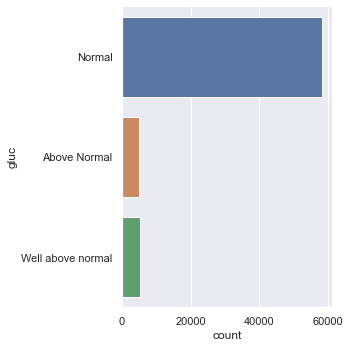

<Figure size 1728x288 with 0 Axes>

In [37]:
# Count of categories for variable "gluc"
print("No. of categories in gluc :", len(glucose["gluc"].unique()))
print(glucose["gluc"].value_counts())

sb.catplot(y = 'gluc', data = glucose, kind = "count")
f = plt.figure(figsize = (24,4))

In [38]:
smoke = pd.DataFrame(int64_items["smoke"])
smoke.describe()

,smoke
count,68667.000000
mean,0.088004
std,0.283303
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [39]:
smoke["smoke"] = smoke["smoke"].replace({1:"Yes", 0:"No"}) #Cleaning smoke dataset
smoke

,smoke
0,No
1,No
2,No
3,No
4,No
...,...
69995,Yes
69996,No
69997,No
69998,No


No. of categories in smoke : 2
No     62624
Yes     6043
Name: smoke, dtype: int64


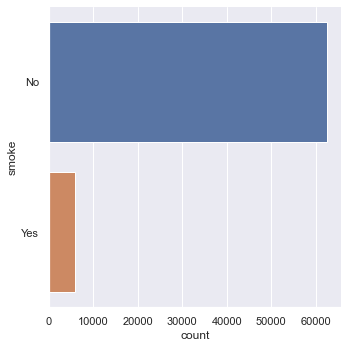

<Figure size 1728x288 with 0 Axes>

In [40]:
# Count of categories for variable "smoke"
print("No. of categories in smoke :", len(smoke["smoke"].unique()))
print(smoke["smoke"].value_counts())

sb.catplot(y = 'smoke', data = smoke, kind = "count")
f = plt.figure(figsize = (24,4))

In [41]:
alcohol = pd.DataFrame(int64_items["alco"])
alcohol.describe()

,alco
count,68667.000000
mean,0.053505
std,0.225039
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [42]:
alcohol["alco"] = alcohol["alco"].replace({1:"Yes", 0:"No"}) #Cleaning alcohol dataset
alcohol

,alco
0,No
1,No
2,No
3,No
4,No
...,...
69995,No
69996,No
69997,Yes
69998,No


No. of categories in alco : 2
No     64993
Yes     3674
Name: alco, dtype: int64


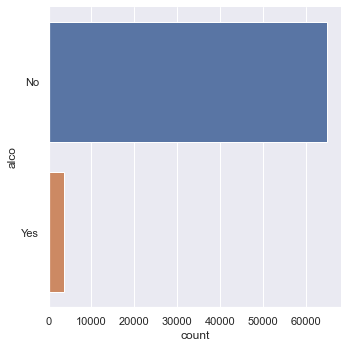

<Figure size 1728x288 with 0 Axes>

In [43]:
# Count of categories for variable "alco"
print("No. of categories in alco :", len(alcohol["alco"].unique()))
print(alcohol["alco"].value_counts())

sb.catplot(y = 'alco', data = alcohol, kind = "count")
f = plt.figure(figsize = (24,4))

In [44]:
physical_Activity = pd.DataFrame(int64_items["active"])
physical_Activity.describe()

,active
count,68667.000000
mean,0.803428
std,0.397409
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [45]:
physical_Activity["active"] = physical_Activity["active"].replace({1:"Yes", 0:"No"}) #Cleaning physical activity dataset
physical_Activity

,active
0,Yes
1,Yes
2,No
3,Yes
4,No
...,...
69995,Yes
69996,Yes
69997,No
69998,No


No. of categories in active : 2
Yes    55169
No     13498
Name: active, dtype: int64


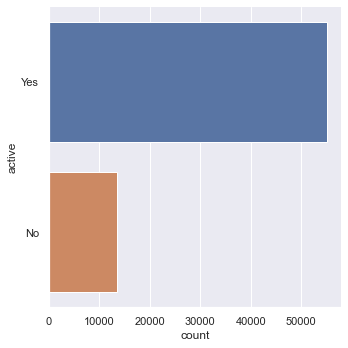

<Figure size 1728x288 with 0 Axes>

In [46]:
# Count of categories for variable "active"
print("No. of categories in active :", len(physical_Activity["active"].unique()))
print(physical_Activity["active"].value_counts())

sb.catplot(y = 'active', data = physical_Activity, kind = "count")
f = plt.figure(figsize = (24,4))

In [47]:
cardio = pd.DataFrame(int64_items["cardio"])
cardio.describe()

,cardio
count,68667.000000
mean,0.494604
std,0.499975
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [48]:
cardio["cardio"] = cardio["cardio"].replace({1:"Yes", 0:"No"}) #Cleaning presence of cardiovascular disease dataset
cardio

,cardio
0,No
1,Yes
2,Yes
3,Yes
4,No
...,...
69995,No
69996,Yes
69997,Yes
69998,Yes


No. of categories in cardio : 2
No     34704
Yes    33963
Name: cardio, dtype: int64


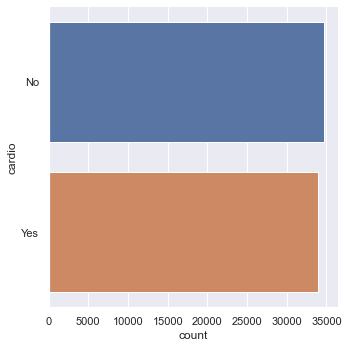

<Figure size 1728x288 with 0 Axes>

In [49]:
# Count of categories for variable "cardio"
print("No. of categories in cardio :", len(cardio["cardio"].unique()))
print(cardio["cardio"].value_counts())

sb.catplot(y = 'cardio', data = cardio, kind = "count")
f = plt.figure(figsize = (24,4))

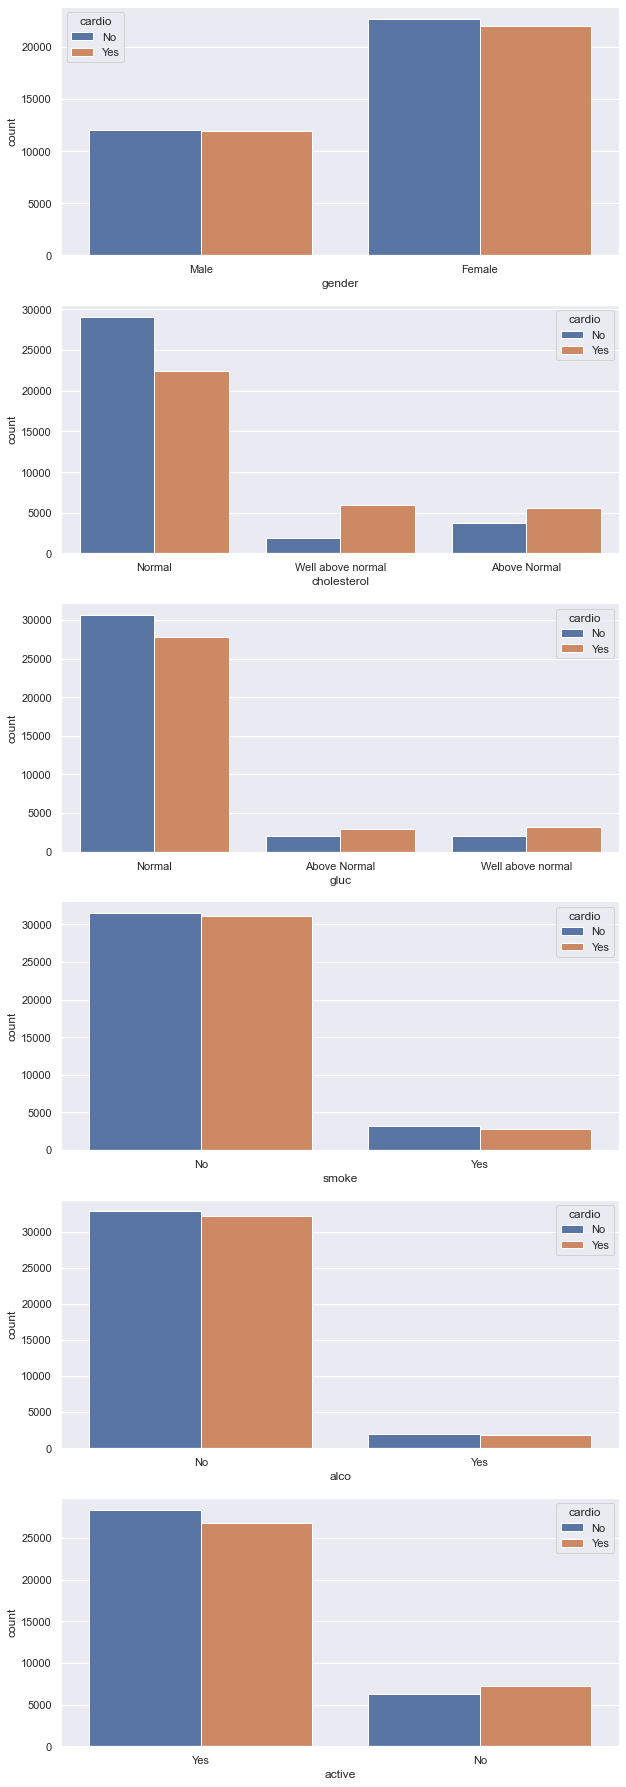

In [50]:
visual = gender
arr = [cholesterol,glucose,smoke,alcohol,physical_Activity,cardio]
for i in arr:
    visual = pd.concat([visual,i],axis = 1)

f,axes = plt.subplots(6,figsize = (10,32))
catvar = ['gender','cholesterol','gluc','smoke','alco','active']
count = 0
for i in catvar:
    sb.countplot(data = visual, x = visual[i] , hue = "cardio", ax = axes[count])
    count+=1

# Brief Analysis:

We've cleaned and prepared our dataset, and have done a basic exploratory analysis and statstical visualisation of variables. Our numeric type variables include age, height, weight, AP_HI (systolic BP) and AP_LO (diastolic BP). As part of data preparation and cleaning, we've converted age in days to age in years and combined height and weight factors into a single new variable, i.e. BMI and added it to our dataset. Moreover, a range of AP_HI and AP_LO has been selected from all 70000 rows to rule out outliers for the time-being. 

Our categorical variables include cholesterol, glucose, alcohol, smoke, physical activity, and most importantly, cardio which tells whether a given patient is affected/not by cardiovascular diseases.

# (Rough) Problem statement:

1) How do all the variables stated above relate with likeliness of cardiovascular diseases in people? Which are the strongest/best indicators of having a cardiovascular disease (most accurate correlation)?

2) Based on 1, which of the indicators strongly predict likeliness of strokes as well? (another dataset can be imported here)

Thus, drawing a connection between cardiovascular and stroke likeliness.

Now, for the prediction models. First, we explore simple decision trees with individual pairs of variables before moving on to multi-variate and more complicated classification.



# Method I: Simple Individual Classification Decision Trees 

# A) Numeric variables

# I) cardio vs age

In [51]:
# cardio is response, age is predictor, both dataframes declared individually before

# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

# Splitting our dataset into Train and Test
age_train, age_test, cardio_train, cardio_test = train_test_split(age, cardio, test_size = 0.25)


# Check the sample sizes
print("Train Set :", cardio_train.shape, age_train.shape)
print("Test Set  :", cardio_test.shape, age_test.shape)


Train Set : (51500, 1) (51500, 1)
Test Set  : (17167, 1) (17167, 1)


In [52]:
# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier
# Create a Decision Tree Classifier object
dectree1 = DecisionTreeClassifier(max_depth = 5)

# Train the Decision Tree Classifier model
dectree1.fit(age_train, cardio_train)

DecisionTreeClassifier(max_depth=5)

<AxesSubplot:xlabel='age', ylabel='cardio'>

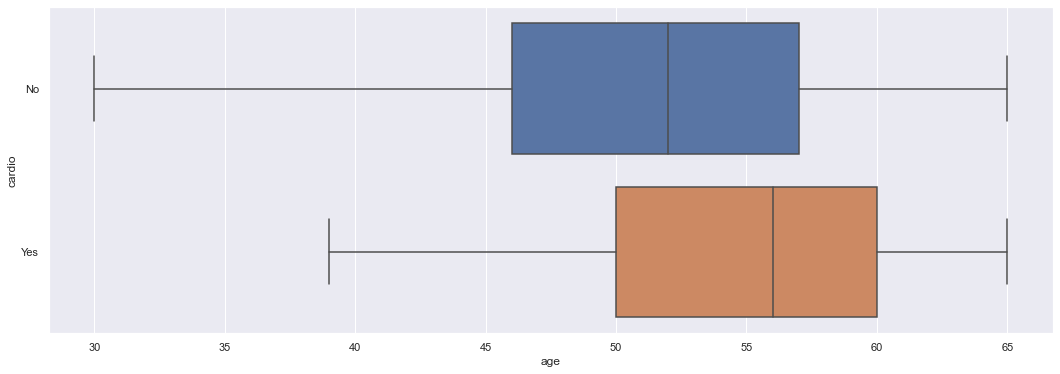

In [53]:
# train data
# Joint dataframe concatenating age and cardio
trainDF1 = pd.concat([age_train, cardio_train], axis = 1).reindex(age_train.index)

# Joint Boxplot of age train against cardio train
f = plt.figure(figsize=(18, 6))
sb.boxplot(x = "age", y = "cardio", data = trainDF1, orient = "h")

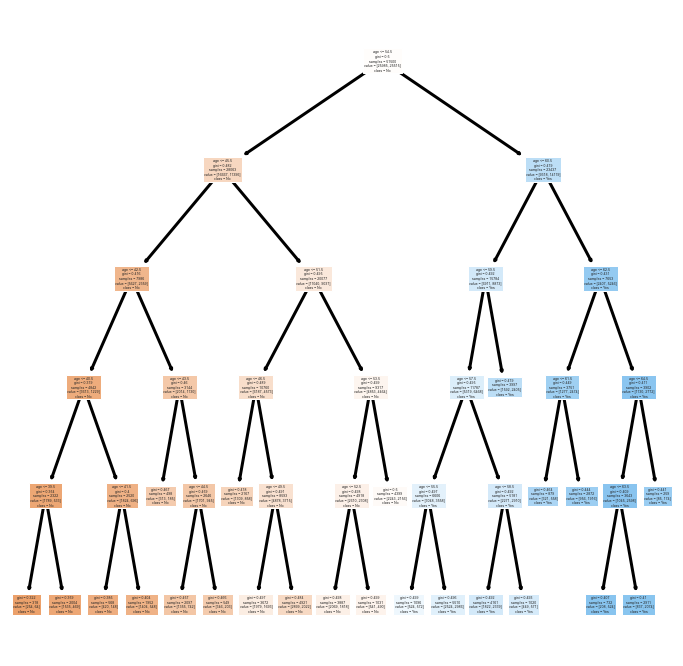

In [54]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
out = plot_tree(dectree1, 
          feature_names = age_train.columns,
          class_names = [str(x) for x in dectree1.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

Classification Accuracy 	: 0.5977864077669903


<AxesSubplot:>

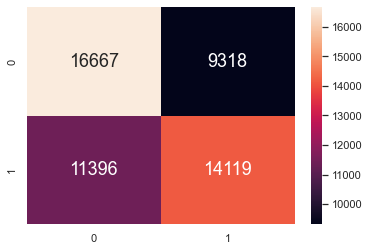

In [55]:
# Predicting cardio corresponding to age train
cardio_train_pred = dectree1.predict(age_train)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree1.score(age_train, cardio_train))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_train, cardio_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Classification Accuracy 	: 0.6015611347352479


<AxesSubplot:>

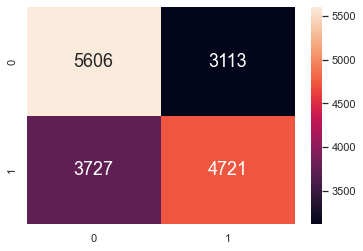

In [56]:
# now for test data
# Predicting cardio corresponding to age test
cardio_test_pred = dectree1.predict(age_test)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree1.score(age_test, cardio_test))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_test, cardio_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# II) cardio vs BMI

In [57]:
# cardio is response, bmi is predictor, both dataframes declared individually before

# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

# Splitting our dataset into Train and Test
bmi_train, bmi_test, cardio_train, cardio_test = train_test_split(bmi, cardio, test_size = 0.25)


# Check the sample sizes
print("Train Set :", cardio_train.shape, bmi_train.shape)
print("Test Set  :", cardio_test.shape, bmi_test.shape)

Train Set : (51500, 1) (51500, 1)
Test Set  : (17167, 1) (17167, 1)


<AxesSubplot:xlabel='BMI', ylabel='cardio'>

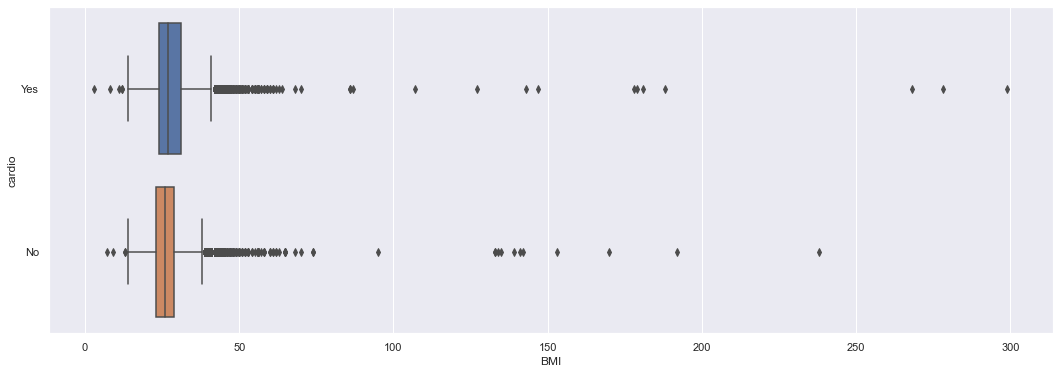

In [58]:
# train data
# Joint dataframe concatenating bmi and cardio
trainDF2 = pd.concat([bmi_train, cardio_train], axis = 1).reindex(bmi_train.index)

# Joint Boxplot of bmi train against cardio train
f = plt.figure(figsize=(18, 6))
sb.boxplot(x = "BMI", y = "cardio", data = trainDF2, orient = "h")


In [59]:
# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree Classifier object
dectree2 = DecisionTreeClassifier(max_depth = 5)


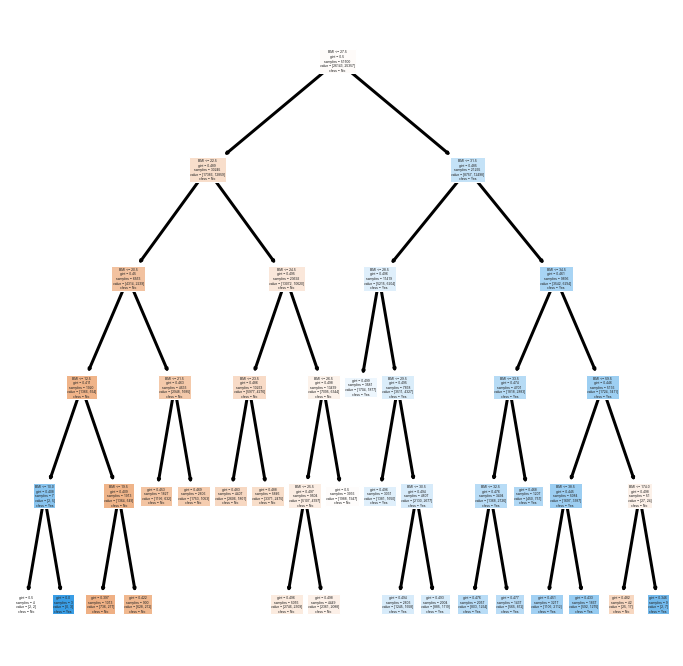

Classification Accuracy 	: 0.5804854368932039


<AxesSubplot:>

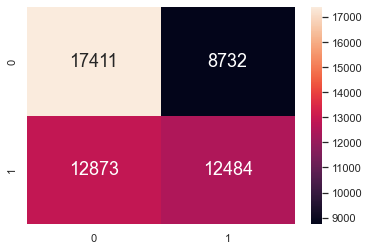

In [60]:
# Train the Decision Tree Classifier model
dectree2.fit(bmi_train, cardio_train)

from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
out = plot_tree(dectree2, 
          feature_names = bmi_train.columns,
          class_names = [str(x) for x in dectree2.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

# Predicting cardio corresponding to bmi train
cardio_train_pred = dectree2.predict(bmi_train)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree2.score(bmi_train, cardio_train))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_train, cardio_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})


Classification Accuracy 	: 0.5886293470029709


<AxesSubplot:>

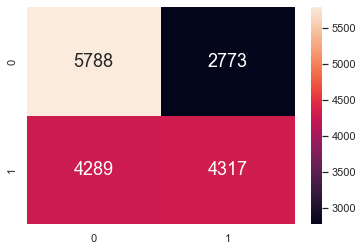

In [61]:
# now for test data
# Predicting cardio corresponding to bmi test
cardio_test_pred = dectree2.predict(bmi_test)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree2.score(bmi_test, cardio_test))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_test, cardio_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# III) cardio vs AP_LO

In [62]:
# cardio is response, AP_LO is predictor, both dataframes declared individually before

# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

# Splitting our dataset into Train and Test
ap_lo_train, ap_lo_test, cardio_train, cardio_test = train_test_split(ap_lo, cardio, test_size = 0.25)


# Check the sample sizes
print("Train Set :", cardio_train.shape, ap_lo_train.shape)
print("Test Set  :", cardio_test.shape, ap_lo_test.shape)

Train Set : (51500, 1) (51500, 1)
Test Set  : (17167, 1) (17167, 1)


'# Joint Swarmplot of AP_LO Train against cardio Train\nf = plt.figure(figsize=(18, 6))\nsb.swarmplot(x = "ap_lo", y = "cardio", data = trainDF3, orient = "h")'

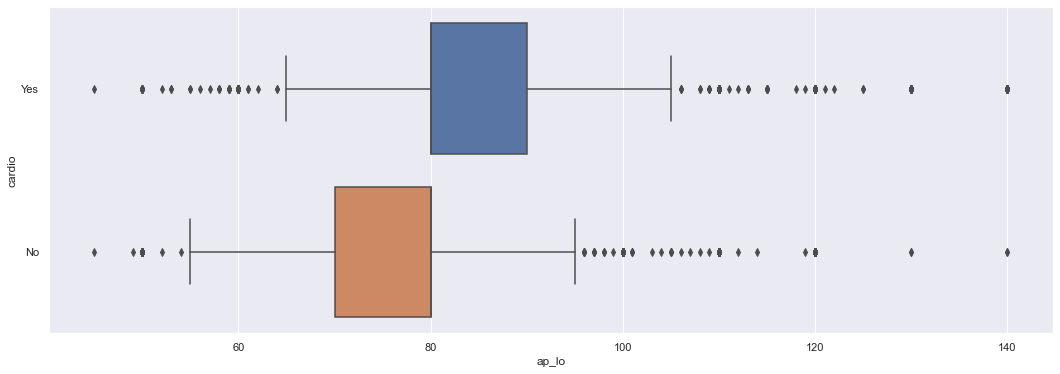

In [63]:
# train data
# Joint dataframe concatenating AP_LO and cardio
trainDF3 = pd.concat([ap_lo_train, cardio_train], axis = 1).reindex(ap_lo_train.index)

# Joint Boxplot of AP_LO train against cardio train
f = plt.figure(figsize=(18, 6))
sb.boxplot(x = "ap_lo", y = "cardio", data = trainDF3, orient = "h")

'''# Joint Swarmplot of AP_LO Train against cardio Train
f = plt.figure(figsize=(18, 6))
sb.swarmplot(x = "ap_lo", y = "cardio", data = trainDF3, orient = "h")'''

In [64]:
# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree Classifier object
dectree3 = DecisionTreeClassifier(max_depth = 5)

# Train the Decision Tree Classifier model
dectree3.fit(ap_lo_train, cardio_train)

DecisionTreeClassifier(max_depth=5)

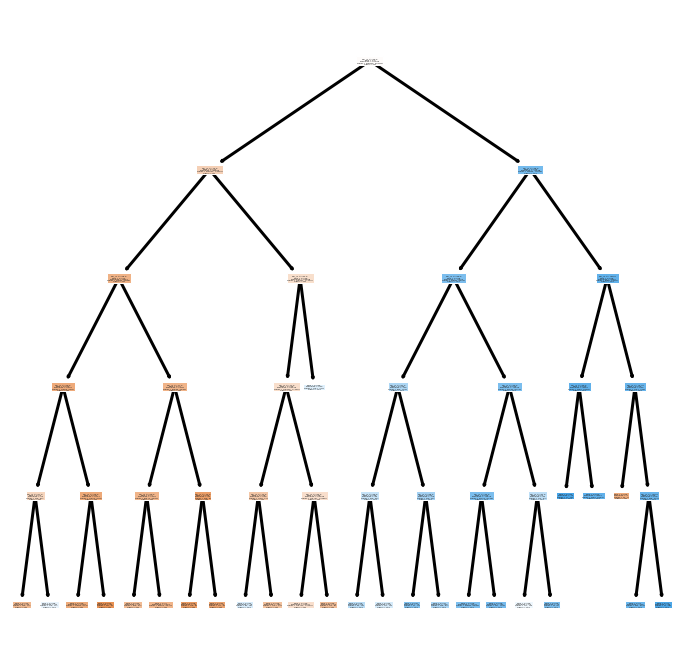

In [65]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
out = plot_tree(dectree3, 
          feature_names = ap_lo_train.columns,
          class_names = [str(x) for x in dectree3.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

Classification Accuracy 	: 0.6581747572815534


<AxesSubplot:>

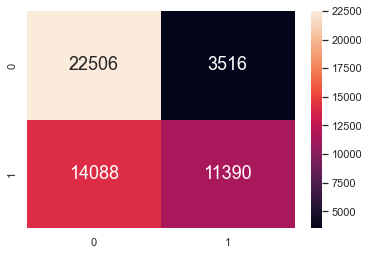

In [66]:
# Predicting cardio corresponding to AP_LO train
cardio_train_pred = dectree3.predict(ap_lo_train)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree3.score(ap_lo_train, cardio_train))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_train, cardio_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Classification Accuracy 	: 0.6624919904467874


<AxesSubplot:>

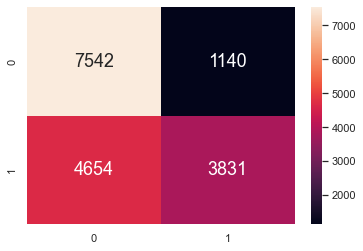

In [67]:
# now for test data
# Predicting cardio corresponding to AP_LO test
cardio_test_pred = dectree3.predict(ap_lo_test)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree3.score(ap_lo_test, cardio_test))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_test, cardio_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# IV) cardio vs AP_HI

In [68]:
# cardio is response, AP_HI is predictor, both dataframes declared individually before

# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

# Splitting our dataset into Train and Test
ap_hi_train, ap_hi_test, cardio_train, cardio_test = train_test_split(ap_hi, cardio, test_size = 0.25)


# Check the sample sizes
print("Train Set :", cardio_train.shape, ap_hi_train.shape)
print("Test Set  :", cardio_test.shape, ap_hi_test.shape)

Train Set : (51500, 1) (51500, 1)
Test Set  : (17167, 1) (17167, 1)


'# Joint Swarmplot of AP_HI Train against cardio Train\nf = plt.figure(figsize=(18, 6))\nsb.swarmplot(x = "ap_hi", y = "cardio", data = trainDF4, orient = "h")'

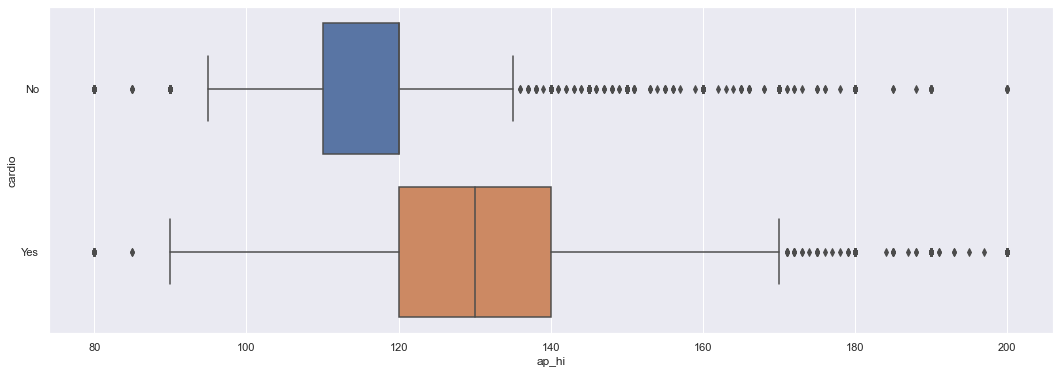

In [69]:
# train data
# Joint dataframe concatenating AP_HI and cardio
trainDF4 = pd.concat([ap_hi_train, cardio_train], axis = 1).reindex(ap_hi_train.index)

# Joint Boxplot of AP_HI train against cardio train
f = plt.figure(figsize=(18, 6))
sb.boxplot(x = "ap_hi", y = "cardio", data = trainDF4, orient = "h")

'''# Joint Swarmplot of AP_HI Train against cardio Train
f = plt.figure(figsize=(18, 6))
sb.swarmplot(x = "ap_hi", y = "cardio", data = trainDF4, orient = "h")'''

In [70]:
# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree Classifier object
dectree4 = DecisionTreeClassifier(max_depth = 2)

# Train the Decision Tree Classifier model
dectree4.fit(ap_hi_train, cardio_train)

DecisionTreeClassifier(max_depth=2)

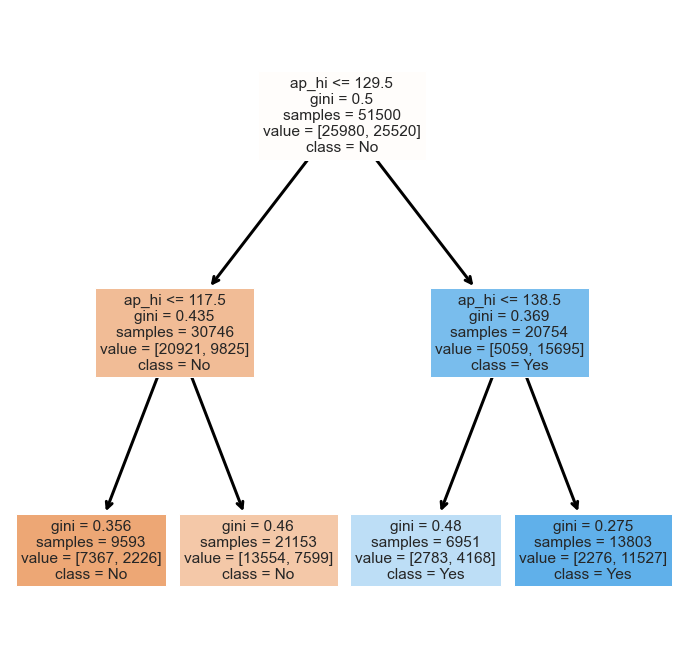

In [71]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
out = plot_tree(dectree4, 
          feature_names = ap_hi_train.columns,
          class_names = [str(x) for x in dectree4.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

Classification Accuracy 	: 0.710990291262136


<AxesSubplot:>

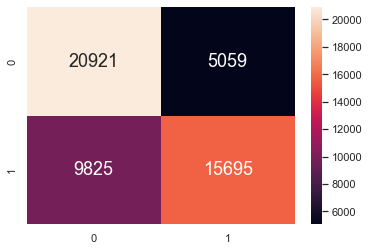

In [72]:
# Predicting cardio corresponding to AP_HI train
cardio_train_pred = dectree4.predict(ap_hi_train)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree4.score(ap_hi_train, cardio_train))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_train, cardio_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Classification Accuracy 	: 0.7174812139570106


<AxesSubplot:>

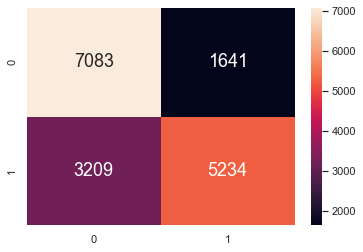

In [73]:
# now for test data
# Predicting cardio corresponding to AP_HI test
cardio_test_pred = dectree4.predict(ap_hi_test)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree4.score(ap_hi_test, cardio_test))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_test, cardio_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# B) Categorical variables

# I) cardio vs gender

In [74]:
# cardio is response, gender is predictor, both dataframes declared individually before

# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

gender = pd.DataFrame(int64_items["gender"])
# Splitting our dataset into Train and Test
gender_train, gender_test, cardio_train, cardio_test = train_test_split(gender, cardio, test_size = 0.25)


# Check the sample sizes
print("Train Set :", cardio_train.shape, gender_train.shape)
print("Test Set  :", cardio_test.shape, gender_test.shape)


Train Set : (51500, 1) (51500, 1)
Test Set  : (17167, 1) (17167, 1)


In [75]:
# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree Classifier object
dectree = DecisionTreeClassifier(max_depth = 5)

# Train the Decision Tree Classifier model
dectree.fit(gender_train, cardio_train)

DecisionTreeClassifier(max_depth=5)

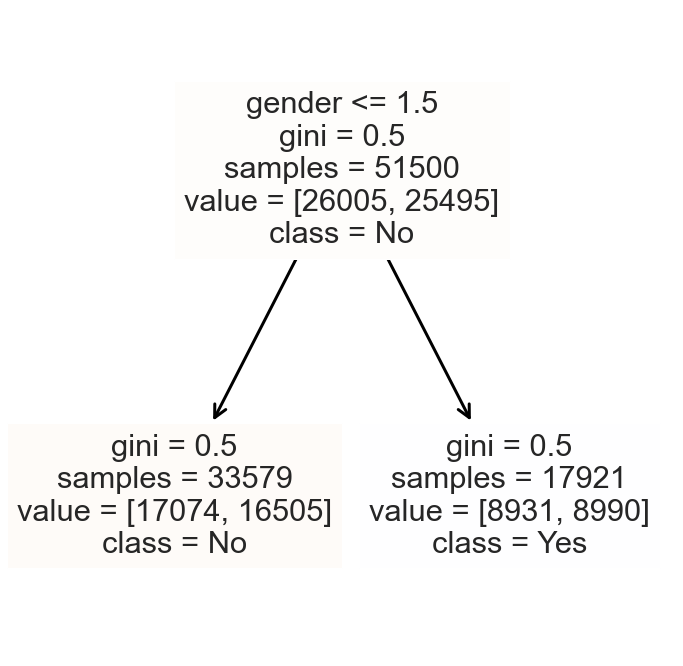

In [76]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
out = plot_tree(dectree, 
          feature_names = gender_train.columns,
          class_names = [str(x) for x in dectree.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

Classification Accuracy 	: 0.5060970873786408


<AxesSubplot:>

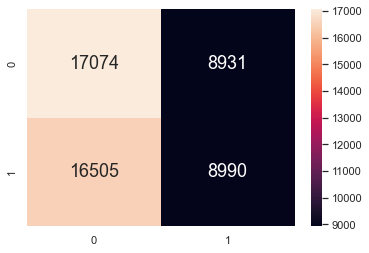

In [77]:
# Predicting cardio corresponding to gender train
cardio_train_pred = dectree.predict(gender_train)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree.score(gender_train, cardio_train))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_train, cardio_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Classification Accuracy 	: 0.5016601619386032


<AxesSubplot:>

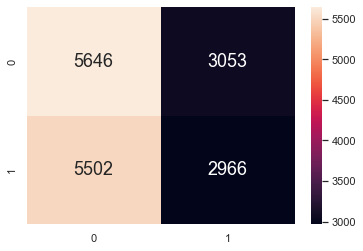

In [78]:
# now for test data
# Predicting cardio corresponding to gender test
cardio_test_pred = dectree.predict(gender_test)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree.score(gender_test, cardio_test))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_test, cardio_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# II) cardio vs cholesterol

In [79]:
# cardio is response, cholesterol is predictor, both dataframes declared individually before

# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

cholesterol = pd.DataFrame(int64_items["cholesterol"])
# Splitting our dataset into Train and Test
cholesterol_train, cholesterol_test, cardio_train, cardio_test = train_test_split(cholesterol, cardio, test_size = 0.25)

# Check the sample sizes
print("Train Set :", cardio_train.shape, cholesterol_train.shape)
print("Test Set  :", cardio_test.shape, cholesterol_test.shape)


Train Set : (51500, 1) (51500, 1)
Test Set  : (17167, 1) (17167, 1)


In [80]:
# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree Classifier object
dectree = DecisionTreeClassifier(max_depth = 5)
dectree.fit(cholesterol_train, cardio_train)

DecisionTreeClassifier(max_depth=5)

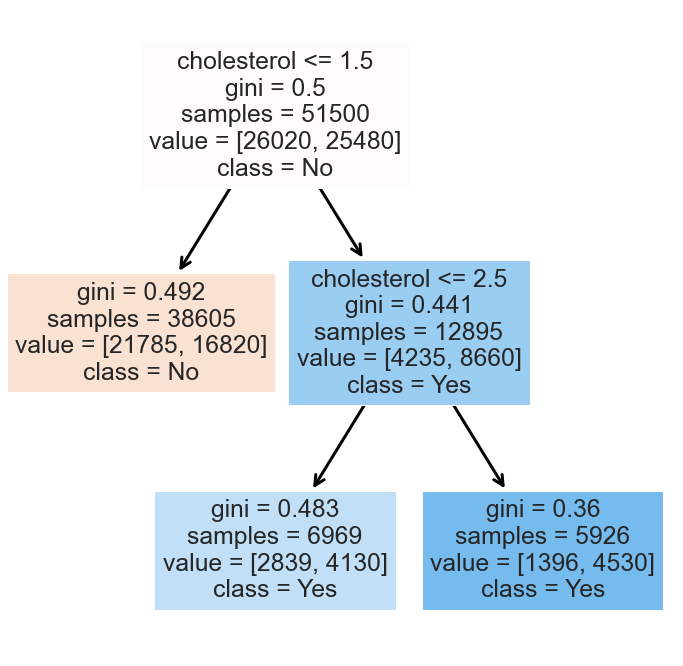

In [81]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
out = plot_tree(dectree, 
          feature_names = cholesterol_train.columns,
          class_names = [str(x) for x in dectree.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

Classification Accuracy 	: 0.5024660194174757


<AxesSubplot:>

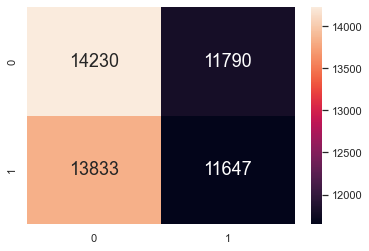

In [82]:
# Predicting cardio corresponding to age train
cardio_train_pred = dectree1.predict(age_train)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree1.score(age_train, cardio_train))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_train, cardio_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Classification Accuracy 	: 0.4978155763965748


<AxesSubplot:>

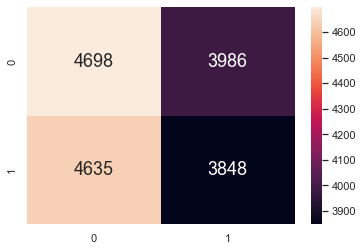

In [83]:
# now for test data
# Predicting cardio corresponding to age test
cardio_test_pred = dectree1.predict(age_test)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree1.score(age_test, cardio_test))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_test, cardio_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# III) cardio vs glucose

In [84]:
# cardio is response, glucose is predictor, both dataframes declared individually before

# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

glucose = pd.DataFrame(int64_items["gluc"])
# Splitting our dataset into Train and Test
glucose_train, glucose_test, cardio_train, cardio_test = train_test_split(glucose, cardio, test_size = 0.25)


# Check the sample sizes
print("Train Set :", cardio_train.shape, glucose_train.shape)
print("Test Set  :", cardio_test.shape, glucose_test.shape)


Train Set : (51500, 1) (51500, 1)
Test Set  : (17167, 1) (17167, 1)


In [85]:
# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree Classifier object
dectree = DecisionTreeClassifier(max_depth = 5)

# Train the Decision Tree Classifier model
dectree.fit(glucose_train, cardio_train)

DecisionTreeClassifier(max_depth=5)

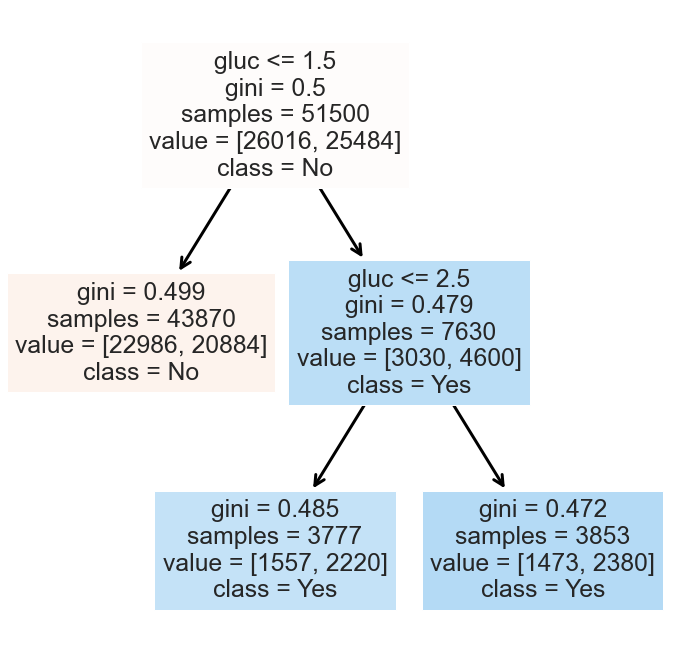

In [86]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
out = plot_tree(dectree, 
          feature_names = glucose_train.columns,
          class_names = [str(x) for x in dectree.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

Classification Accuracy 	: 0.5356504854368932


<AxesSubplot:>

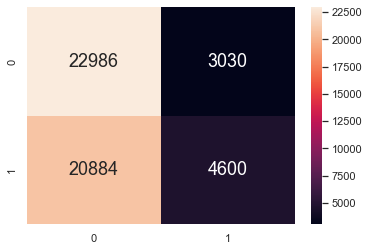

In [87]:
# Predicting cardio corresponding to glucose train
cardio_train_pred = dectree.predict(glucose_train)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree.score(glucose_train, cardio_train))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_train, cardio_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Classification Accuracy 	: 0.5384749810683288


<AxesSubplot:>

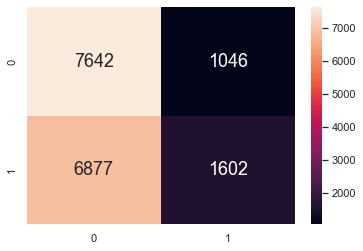

In [88]:
# now for test data
# Predicting cardio corresponding to glucose test
cardio_test_pred = dectree.predict(glucose_test)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree.score(glucose_test, cardio_test))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_test, cardio_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# IV) cardio vs smoke

In [89]:
# cardio is response, smoke is predictor, both dataframes declared individually before

# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

smoke = pd.DataFrame(int64_items["smoke"])
# Splitting our dataset into Train and Test
smoke_train, smoke_test, cardio_train, cardio_test = train_test_split(smoke, cardio, test_size = 0.25)


# Check the sample sizes
print("Train Set :", cardio_train.shape, smoke_train.shape)
print("Test Set  :", cardio_test.shape, smoke_test.shape)


Train Set : (51500, 1) (51500, 1)
Test Set  : (17167, 1) (17167, 1)


In [90]:
# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree Classifier object
dectree = DecisionTreeClassifier(max_depth = 5)

# Train the Decision Tree Classifier model
dectree.fit(smoke_train, cardio_train)

DecisionTreeClassifier(max_depth=5)

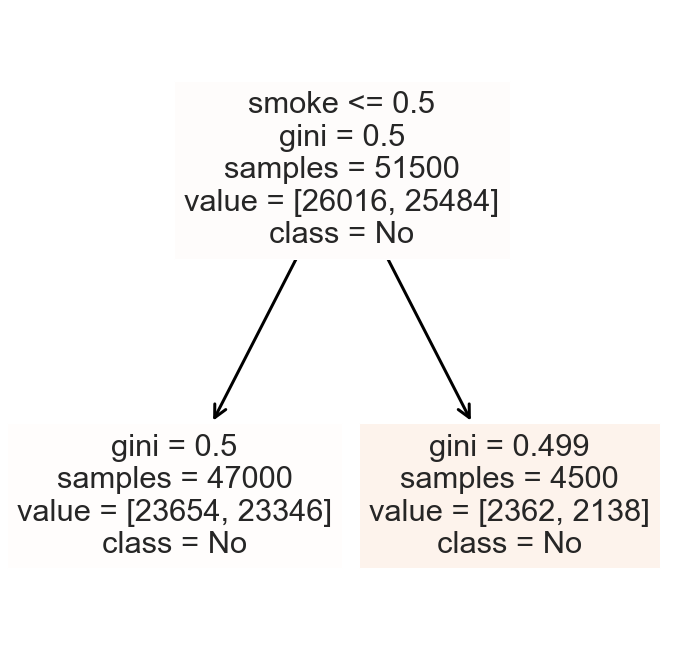

In [91]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
out = plot_tree(dectree, 
          feature_names = smoke_train.columns,
          class_names = [str(x) for x in dectree.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

Classification Accuracy 	: 0.5051650485436893


<AxesSubplot:>

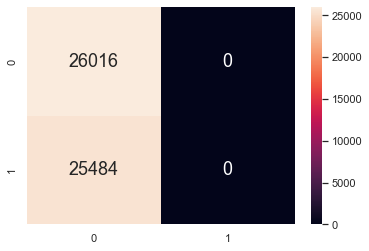

In [92]:
# Predicting cardio corresponding to smoke train
cardio_train_pred = dectree.predict(smoke_train)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree.score(smoke_train, cardio_train))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_train, cardio_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Classification Accuracy 	: 0.5060872604415448


<AxesSubplot:>

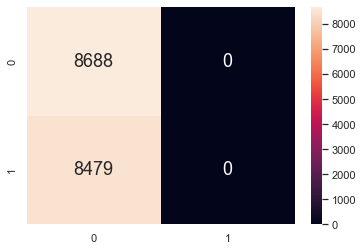

In [93]:
# now for test data
# Predicting cardio corresponding to smoke test
cardio_test_pred = dectree.predict(smoke_test)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree.score(smoke_test, cardio_test))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_test, cardio_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# V) cardio vs alcohol

In [94]:
# cardio is response, alcohol is predictor, both dataframes declared individually before

# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

alcohol = pd.DataFrame(int64_items["alco"])
# Splitting our dataset into Train and Test
alcohol_train, alcohol_test, cardio_train, cardio_test = train_test_split(alcohol, cardio, test_size = 0.25)


# Check the sample sizes
print("Train Set :", cardio_train.shape, alcohol_train.shape)
print("Test Set  :", cardio_test.shape, alcohol_test.shape)


Train Set : (51500, 1) (51500, 1)
Test Set  : (17167, 1) (17167, 1)


In [95]:
# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree Classifier object
dectree = DecisionTreeClassifier(max_depth = 5)

# Train the Decision Tree Classifier model
dectree.fit(alcohol_train, cardio_train)

DecisionTreeClassifier(max_depth=5)

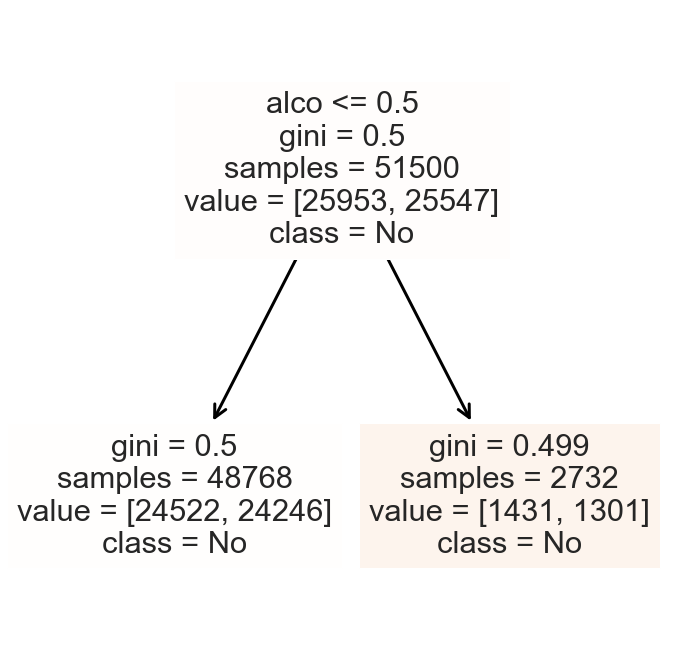

In [96]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
out = plot_tree(dectree, 
          feature_names = alcohol_train.columns,
          class_names = [str(x) for x in dectree.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

Classification Accuracy 	: 0.5039417475728155


<AxesSubplot:>

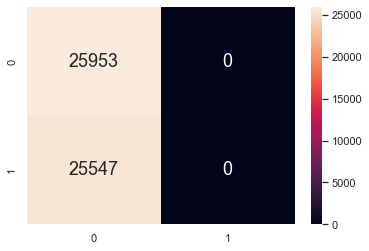

In [97]:
# Predicting cardio corresponding to alcohol train
cardio_train_pred = dectree.predict(alcohol_train)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree.score(alcohol_train, cardio_train))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_train, cardio_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Classification Accuracy 	: 0.5097570920952991


<AxesSubplot:>

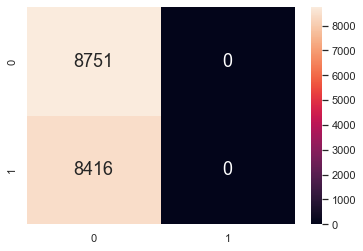

In [98]:
# now for test data
# Predicting cardio corresponding to alcohol test
cardio_test_pred = dectree.predict(alcohol_test)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree.score(alcohol_test, cardio_test))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_test, cardio_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# VI) cardio vs physical activity (exercise)

In [99]:
# cardio is response, active is predictor, both dataframes declared individually before

# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

active = pd.DataFrame(int64_items["active"])
# Splitting our dataset into Train and Test
active_train, active_test, cardio_train, cardio_test = train_test_split(active, cardio, test_size = 0.25)


# Check the sample sizes
print("Train Set :", cardio_train.shape, active_train.shape)
print("Test Set  :", cardio_test.shape, active_test.shape)


Train Set : (51500, 1) (51500, 1)
Test Set  : (17167, 1) (17167, 1)


In [100]:
# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree Classifier object
dectree = DecisionTreeClassifier(max_depth = 5)

# Train the Decision Tree Classifier model
dectree.fit(active_train, cardio_train)

DecisionTreeClassifier(max_depth=5)

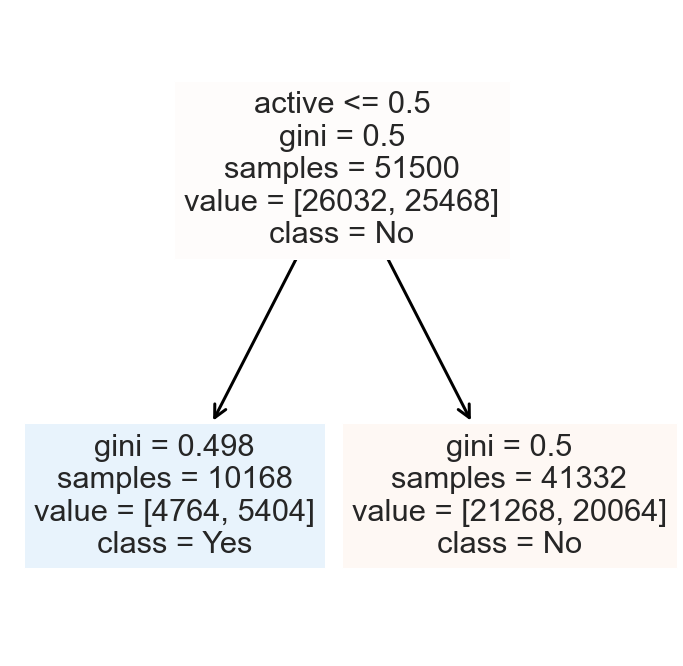

In [101]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
out = plot_tree(dectree, 
          feature_names = active_train.columns,
          class_names = [str(x) for x in dectree.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

Classification Accuracy 	: 0.5179029126213592


<AxesSubplot:>

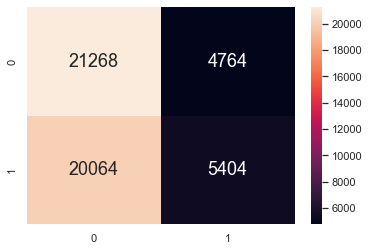

In [102]:
# Predicting cardio corresponding to active train
cardio_train_pred = dectree.predict(active_train)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree.score(active_train, cardio_train))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_train, cardio_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Classification Accuracy 	: 0.5189025455816392


<AxesSubplot:>

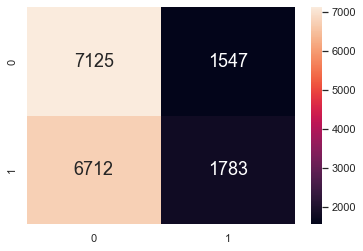

In [103]:
# now for test data
# Predicting cardio corresponding to active test
cardio_test_pred = dectree.predict(active_test)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree.score(active_test, cardio_test))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_test, cardio_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# Based on simple decision tree accuracies and our correlation heatmaps, we observe that top 6 most important variables in determining cardiovascular disease likeliness include: AP_HI, AP_LO, age, BMI, glucose and physical activity. We thus, limit our prediction models to these 6 stated variables and try to improve the prediction further.

# Methods of improving our prediction:
### 1. Trimming variable outliers
### 2. Selecting approiate variables (AP_HI, AP_LO, age, BMI, glucose and physical activity)
### 3. Utilising other models => Logistic Regression, Naive, Random forest
### 4. Tune the algorithms => Setting dectree(max_depth = 10), LogisticRegression(max_iter = 10000) and using other variants of logistic regression(polynomial)
### We have improved our ml accuracy from 50% to 82% 

# It would be a good idea to trim the BMI anomalies as there are huge range of anomalies

In [104]:
# Q1 is at 25% and Q3 is at 75%
Q1 = df1['BMI'].quantile(0.25)
Q3 = df1['BMI'].quantile(0.75)
IQR = Q3 - Q1

df1 = df1[~((df1['BMI'] < (Q1 - 1.5 * IQR)) | (df1['BMI'] > (Q3 + 1.5 * IQR)))] #Removing anomalies beyond Q1 and Q3

In [105]:
#dict for recording accuracy
acc = {}

# I) Multi-Variate Classification Tree

In [106]:
df1

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,22
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,35
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1,24
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,29
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,58,1,165,80.0,150,80,1,1,0,0,1,1,29
69995,99993,53,2,168,76.0,120,80,1,1,1,0,1,0,27
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1,31
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1,27


In [107]:
df1.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
count,66648.000000,66648.000000,66648.000000,66648.000000,66648.000000,66648.000000,66648.000000,66648.000000,66648.000000,66648.000000,66648.000000,66648.000000,66648.000000,66648.000000
mean,49970.657544,53.298118,1.355014,164.579972,73.035533,126.249550,81.173043,1.356365,1.220352,0.089080,0.053430,0.804300,0.488792,26.964590
std,28859.039176,6.773993,0.478521,7.801154,12.708355,16.364627,9.374567,0.672405,0.566280,0.284861,0.224891,0.396741,0.499878,4.414694
min,0.000000,30.000000,1.000000,120.000000,28.000000,80.000000,45.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,15.000000
25%,24978.250000,48.000000,1.000000,159.000000,64.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,24.000000
50%,50005.500000,54.000000,1.000000,165.000000,71.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.000000
75%,74879.250000,58.000000,2.000000,170.000000,80.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.000000
max,99999.000000,65.000000,2.000000,207.000000,135.000000,200.000000,140.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,39.000000


In [108]:
# Extract Response and Predictors
# cardio is response, all the other numeric variables (saved in dataframe X) are predictors

X = pd.DataFrame(df1[["ap_hi", "ap_lo", "age", "BMI","gluc","active"]])

# Splitting the Dataset into Train and Test
X_train, X_test, cardio_train, cardio_test = train_test_split(X, df1['cardio'], test_size = 0.25)

# Check the sample sizes
print("Train Set :", cardio_train.shape, X_train.shape)
print("Test Set  :", cardio_test.shape, X_test.shape)


Train Set : (49986,) (49986, 6)
Test Set  : (16662,) (16662, 6)


In [109]:
# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 10)  # create the decision tree object
dectree.fit(X_train, cardio_train)                    # train the decision tree model

DecisionTreeClassifier(max_depth=10)

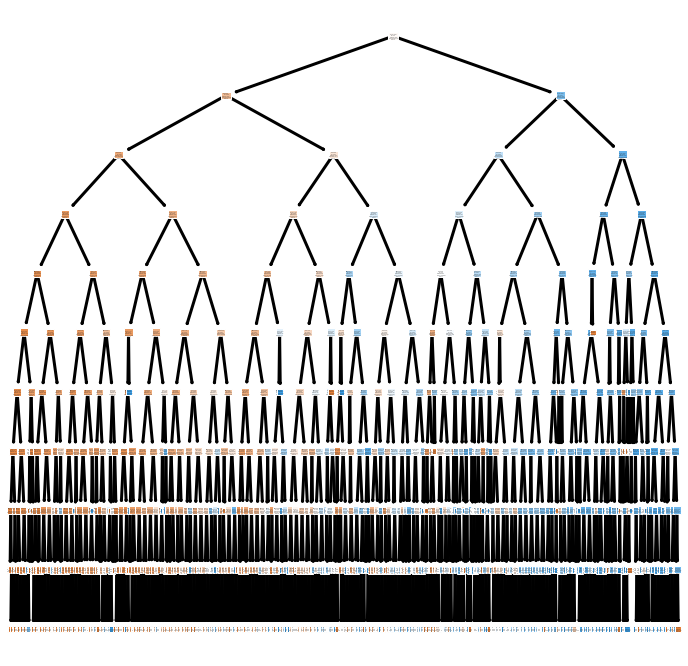

In [110]:
# Plot the trained Decision Tree, will take a while as it has 10 depths
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
out = plot_tree(dectree, 
          feature_names = X_train.columns,
          class_names = [str(x) for x in dectree.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

In [111]:
# Predict Legendary values corresponding to Total
cardio_train_pred = dectree.predict(X_train)
cardio_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, cardio_train))
print()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7367262833593407



Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7185211859320609



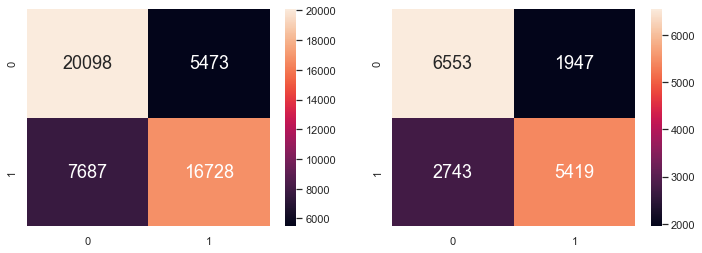

In [112]:
# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, cardio_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(cardio_train, cardio_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(cardio_test, cardio_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

#Record down the accu 
acc['Decision Tree Train Accuracy'] = dectree.score(X_train, cardio_train)
acc['Decision Tree Test Accuracy'] = dectree.score(X_test, cardio_test)

# II) Logistic Regression Model

In [113]:
from sklearn.model_selection import train_test_split
X = pd.DataFrame(df1[["ap_hi", "ap_lo", "age", "BMI","gluc","active"]])
# Splitting the Dataset into Train and Test
X_train, X_test, cardio_train, cardio_test = train_test_split(X,df1["cardio"], test_size = 0.25)

In [114]:
from sklearn.linear_model import LogisticRegression
LogReg = LogisticRegression(max_iter= 100000)
LogReg.fit(X_train,cardio_train)

LogisticRegression(max_iter=100000)

In [115]:
cardio_train_predict = LogReg.predict(X_train)
cardio_test_predict = LogReg.predict(X_test)

In [116]:
#logregtrainacc = (LogReg.score(X_train,cardio_train)*100).round(2)
#logregtestacc = (LogReg.score(X_test,cardio_test)*100).round(2)

print("Training data's accuracy:", LogReg.score(X_train,cardio_train))
print("Test data's accuracy:", LogReg.score(X_test,cardio_test))

#Record down the accu 
acc['Logistic Regression Train Accuracy'] = LogReg.score(X_train,cardio_train)
acc['Logistic Regression Test Accuracy'] = LogReg.score(X_test,cardio_test)

Training data's accuracy: 0.7207418077061577
Test data's accuracy: 0.7226623454567279


<AxesSubplot:>

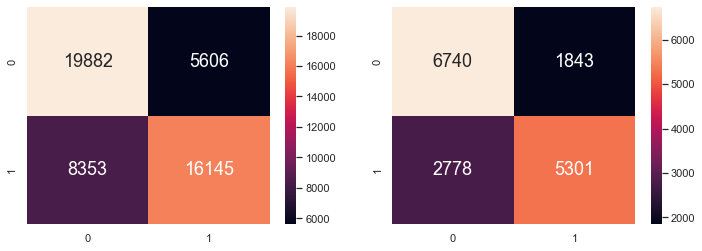

In [117]:
from sklearn.metrics import confusion_matrix
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(cardio_train, cardio_train_predict),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(cardio_test, cardio_test_predict), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

# III) Random Forest Classifier for trees

In [118]:
# Extract Response and Predictors
# cardio is response, the other variables (saved in dataframe X) are predictors

X = pd.DataFrame(df1[["ap_hi", "ap_lo", "age", "BMI", "gluc", "active"]])

# Splitting the Dataset into Train and Test
X_train, X_test, cardio_train, cardio_test = train_test_split(X, df1['cardio'], test_size = 0.25)

# Check the sample sizes
print("Train Set :", cardio_train.shape, X_train.shape)
print("Test Set  :", cardio_test.shape, X_test.shape)

Train Set : (49986,) (49986, 6)
Test Set  : (16662,) (16662, 6)


In [119]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier()

In [120]:
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,np.ravel(cardio_train))
cardio_train_pred = clf.predict(X_train)
cardio_test_pred = clf.predict(X_test)

In [121]:
X_train

,ap_hi,ap_lo,age,BMI,gluc,active
41316,110,70,56,27,1,0
43484,80,60,58,25,1,0
28816,120,80,65,20,1,1
46211,130,90,52,36,1,1
15771,120,80,63,27,1,1
...,...,...,...,...,...,...
68200,130,80,48,33,1,1
68431,90,60,50,22,1,1
41495,120,75,64,23,1,0
4565,120,90,52,23,1,1


In [122]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
print("Train Data's Accuracy:",metrics.accuracy_score(cardio_train, cardio_train_pred))
print("Test Data's Accuracy:",metrics.accuracy_score(cardio_test, cardio_test_pred))

acc['Random Forestn Train Accuracy'] = metrics.accuracy_score(cardio_train, cardio_train_pred)
acc['Random Forest Tree Test Accuracy'] = metrics.accuracy_score(cardio_test, cardio_test_pred)

Train Data's Accuracy: 0.8155283479374225
Test Data's Accuracy: 0.6897131196735086


# IV) Naive Bayes Classifier

In [123]:
X = pd.DataFrame(df1[["ap_hi", "ap_lo", "age", "BMI", "gluc", "active"]])
# Splitting the Dataset into Train and Test
X_train, X_test, cardio_train, cardio_test = train_test_split(X, df1['cardio'], test_size = 0.25)

# Check the sample sizes
print("Train Set :", cardio_train.shape, X_train.shape)
print("Test Set  :", cardio_test.shape, X_test.shape)

Train Set : (49986,) (49986, 6)
Test Set  : (16662,) (16662, 6)


In [124]:
X_train

,ap_hi,ap_lo,age,BMI,gluc,active
60614,110,80,40,32,1,1
24478,120,80,40,24,1,1
14261,110,80,41,21,1,1
49863,120,80,56,26,1,1
69886,120,80,50,27,1,1
...,...,...,...,...,...,...
4575,110,70,50,30,1,1
32941,130,90,56,22,1,0
43058,120,80,42,25,1,1
66965,120,90,48,20,1,1


In [125]:
cols = X_train.columns

In [126]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

'''X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])'''

'X_train = pd.DataFrame(X_train, columns=[cols])\nX_test = pd.DataFrame(X_test, columns=[cols])'

In [127]:
# train a Gaussian Naive Bayes classifier on the training set
from sklearn.naive_bayes import GaussianNB

# instantiate the model
gnb = GaussianNB()

# fit the model
gnb.fit(X_train, np.ravel(cardio_train))

GaussianNB()

In [128]:
cardio_train_pred = gnb.predict(X_train)
cardio_test_pred = gnb.predict(X_test)

In [129]:
from sklearn.metrics import accuracy_score
print('Train Model accuracy score: {0:0.4f}'. format(accuracy_score(cardio_train, cardio_train_pred)))
print('Test Model accuracy score: {0:0.4f}'. format(accuracy_score(cardio_test, cardio_test_pred)))

acc['Naive Bayes Classifier Train Accuracy'] = accuracy_score(cardio_train, cardio_train_pred)
acc['Naive Bayes Classifier Tree Test Accuracy'] = accuracy_score(cardio_test, cardio_test_pred)

Train Model accuracy score: 0.7066
Test Model accuracy score: 0.7062


# IV) Polynomial Logistic Regression

In [130]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

X = pd.DataFrame(df1[["ap_hi", "ap_lo", "age", "BMI", "gluc", "active"]])
# Splitting the Dataset into Train and Test
X_train, X_test, cardio_train, cardio_test = train_test_split(X, df1['cardio'], test_size = 0.25)

# Check the sample sizes
print("Train Set :", cardio_train.shape, X_train.shape)
print("Test Set  :", cardio_test.shape, X_test.shape)

Train Set : (49986,) (49986, 6)
Test Set  : (16662,) (16662, 6)


In [131]:
poly = PolynomialFeatures(degree = 2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X_train)
X_poly.shape

(49986, 27)

In [132]:
lr = LogisticRegression(max_iter= 100000)
lr.fit(X_poly, np.ravel(cardio_train))

LogisticRegression(max_iter=100000)

In [133]:
print("Model train accuracy:" , lr.score(poly.transform(X_train), cardio_train))
print("Model test accuracy:" , lr.score(poly.transform(X_test), cardio_test))

acc['Polynomial Logistic Regression Train Accuracy'] = lr.score(poly.transform(X_train), cardio_train)
acc['Polynomial Logistic Regression Tree Test Accuracy'] = lr.score(poly.transform(X_test), cardio_test)

Model train accuracy: 0.7227823790661385
Model test accuracy: 0.7238026647461289


In [134]:
accdf = pd.DataFrame(acc,index = [0])
accdf

,Decision Tree Train Accuracy,Decision Tree Test Accuracy,Logistic Regression Train Accuracy,Logistic Regression Test Accuracy,Random Forestn Train Accuracy,Random Forest Tree Test Accuracy,Naive Bayes Classifier Train Accuracy,Naive Bayes Classifier Tree Test Accuracy,Polynomial Logistic Regression Train Accuracy,Polynomial Logistic Regression Tree Test Accuracy
0,0.736726,0.718521,0.720742,0.722662,0.815528,0.689713,0.706638,0.706218,0.722782,0.723803


| ML | Train data accuracy | Test data accuracy | 
| --- | --- | --- |
| Decision Tree | ~73.77% | ~71.89% | 
| Logistic Regression | ~72.08% | ~72.00% | 
| Random Forest Classifier | ~81.53% | ~68.92% | 
| Naive Bayes Classifier | ~70.72% | ~70.68% | 
| Polynomial Logistic Regresstion | ~72.47% | ~72.04% | 

# Decision tree is improved with random forest classifier and logistic regression is improved with polynomial logisitic Regression. However, the difference between train data accuracy and test data accuracy for random forest classifier is more than polynomial logistic regression. Hence, polynomial logistic regression is best suited for consistent cardiovascular disease prediction

# Find out whether you are at risk of a cardiovascular disease at the end!

## Functions of inputs

In [135]:
def inputAge():
    while True: # the input will continue running if you have entered a wrong number. 
                #It will only stopped running once your input is satisfied
        value = input('What is your age? ')
        try:
           value = int(value) #Ensuring that the entered value is int
        except ValueError: #if value is not int, it will throw an error
               print('Valid number, please')
               continue
        if 0 <= value <= 100:
                return value
                break
        else:
               print('Invalid range, please try again')

In [136]:
def inputBMI():
    while True: # the input will continue running if you have entered a wrong number. 
                #It will only stopped running once your input is satisfied
        weight = input('What is your weight in Kg (from 45kg to 150kg)? ')
        height = input('What is your height in cm (from 155cm to 195cm)? ')
        try:
           weight = float(weight) #Ensuring that the entered value is float
           height = float(height) #if value is not float, it will throw an error
        except ValueError:
               print('Valid number, please')
               continue
        if (45 <= weight <= 150) and (155 <= height <= 195) :
                bmi =  (weight/ (height*height)) * 10000
                return int(bmi) #Return bmi as int
                break
        else:
               print('Invalid range, please try again')

In [137]:
def inputBP():
    while True: 
        ap_hi = input('What is your last recorded Systolic Blood Pressure(Top number)? Acceptable range is between 75 to 200  ')
        ap_lo = input('What is your last recorded Diastolic blood pressure(Bottom number)? Acceptable range is between between 45 to 140? ')
        try:
           ap_hi = int(ap_hi)
           ap_lo = int(ap_lo)
        except ValueError:
               print('Valid number, please')
               continue
        if (75 < ap_hi < 200) and (45 < ap_lo < 140) and (ap_hi > ap_lo):
                return ap_hi, ap_lo
                break
        else:
               print('Invalid range, please try again')

In [138]:
def inputGluc():
    while True:
        value = input('What is your estimate glucose level? Put 1 if unsure. 1: Normal, 2: Above Normal, 3: Well above Normal  ')
        try:
           value = int(value)
        except ValueError:
               print('Valid number, please')
               continue
        if 1 <= value <= 3:
                return value
                break
        else:
               print('Invalid value, please try again')

In [139]:
def inputActive():
    while True:
        value = input('Are you an active person ? 0: No, 1: Yes ')
        try:
           value = int(value)
        except ValueError:
               print('Valid number, please')
               continue
        if 0 <= value <= 1:
                return value
                break
        else:
               print('Invalid value, please try again')

# Function to predict cardio disease

In [140]:
#factors "ap_hi", "ap_lo", "age", "BMI","gluc","active"
#df is ap_hi	ap_lo	age	BMI	gluc	active
def prediction(age,BMI,ap_hi,ap_lo,gluc,act):
    x = pd.DataFrame({"ap_hi": [ap_hi], "ap_lo": [ap_lo], "age": [age], "BMI": [BMI], "gluc": [gluc], "active":[act]})
    #Convert raw data into a dataframe 
    
    X_poly = poly.fit_transform(x) # for poly logistic regression, convert data with polynomial
    
    #Uncomment one of these lines to use the ml models
    #cardio = dectree.predict(x) # Decision tree predict
    #cardio = LogReg.predict(x) # Logistic Regression predict
    #cardio = clf.predict(x) # Random forest predict
    #cardio = gnb.predict(x) # Naive Bayes
    
    #Comment this if you want to use other model
    cardio = lr.predict(X_poly) # Poly logistic regression predict
    
    return cardio #Return either 0 or 1

In [142]:
# To show which bp group are you in
def bp_status(ap_hi,ap_lo):
    status = ""
    if (ap_hi < 120 and ap_lo < 80): 
        status = "Normal"
    if (120 <=ap_hi <= 129 and ap_lo < 80):
        status = "Elevated"
    if (130 <= ap_hi <= 139 or 80 <= ap_lo <= 89):
        status = "High blood pressure"
    if (ap_hi >= 140 or ap_lo >= 90):
        status = "High blood pressure stage 2"
    if (ap_hi >= 180 or ap_lo >= 120):
        status = "Hypertensive crisis"
    return status

In [149]:
# To show which BMI group are you in 
def bmi_status(bmi):
    status = ""
    if (bmi <= 19): 
        status = "Underweight"
    if (20 <= bmi <= 25): 
        status = "Normal"
    if (26 <= bmi <= 30): 
        status = "Overweight"
    if (31 <= bmi <= 35): 
        status = "Obese"
    if (bmi >= 36):
        status = "Extremely Obese"
    return status

In [153]:
# This function will ask the user for input and it will determine whether he/she is at risk of any cardiovascular disease
def datainput():
    #Get age,bmi,ap_hi,ap_lo,gluc,activeness
    age = inputAge()
    BMI = inputBMI()
    ap_hi,ap_lo = inputBP()
    gluc = inputGluc()
    act = inputActive()
    
    cardio = prediction(age,BMI,ap_hi,ap_lo,gluc,act) #Result of cardio
    
    print("Your BMI: ", str(BMI), "and you are", str(bmi_status(BMI)))
    if cardio != 1: # 1: At Risk, 0: Not at risk
        print("Congrats, you are not at risk of any cardiovascular disease")
        print("Your blood pressure:", str(ap_hi), "/", str(ap_lo), "and it is" ,str(bp_status(ap_hi,ap_lo)))
    else:
        print("You are currently at risk of cardiovascular disease")
        

# Find out whether you are at risk of a cardiovascular disease!

In [152]:
# Run this cell by pressing the run button or ctrl + enter
datainput()

What is your age? 24
What is your weight in Kg (from 45kg to 150kg)? 82.5
What is your height in cm (from 155cm to 195cm)? 175
What is your last recorded Systolic Blood Pressure(Top number)? Acceptable range is between 75 to 200  134
What is your last recorded Diastolic blood pressure(Bottom number)? Acceptable range is between between 45 to 140? 65
What is your estimate glucose level? Put 1 if unsure. 1: Normal, 2: Above Normal, 3: Well above Normal  2
Are you an active person ? 0: No, 1: Yes 1
Your BMI:  26 and you are Overweight
Congrats, you are not at risk of any cardiovascular disease
Your blood pressure: 134 / 65 as it is High blood pressure
